# LAPW project

This project is adapted from Thijssen.

This is currently broken.

Stuff used:
- Thijssen book
- Wave Functions and Energy Levels for Cu+ as Found by the Slater Approximation to the Hartree-Fock Equations paper by Pratt
- Energy Band Structure of Copper by Glenn A. Burdick
- Use of energy derivative of the radial solution in an
augmented plane wave method: application to
copper by Koelling and Arbman
- APW code from: https://github.com/aromanro/APW/tree/master



In [1]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import integrate
import functools
from scipy.linalg import eigh



In [2]:
#constants
a = 6.8219117
vol = (a**3)/4

#simulation parameters
l_max = 8
nLim = 2

#recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [3]:
rs = np.linspace(0,1,num=10**4)
h = rs[1] - rs[0]
h2 = h**2
h12 = h2/12
r_max = rs[-1]

def V(r):
    term1 = 29.*np.exp(-2.3151241717834*(r**0.81266614122432) + (2.1984250222603E-2)*(r**4.2246376280056))
    term2 = -0.15595606773483*r - (3.1350051440417E-3)*r**2 + (5.1895222293006E-2)*r**3 - (2.8027608685637E-2)*r**4
    return -(term1 + term2)/r

Es = [0.1,0.1,0.1,0.125,0.15,0.2,0.25,0.3,0.35,0.4] 

#explain where these come from, are these required to get good results

def f(r,l):
    if r == 0:
        return 0
    return l*(l+1)/r**2 + 2*(V(r) - Es[l]) #Rydberg units

F = np.empty([l_max,len(rs)])
for l in range(l_max):
    for i,r in enumerate(rs):
        F[l,i] = f(rs[i],l)



#empty global variables
RMax = np.empty(l_max)
RDashMax = np.empty(l_max)
RDotMax = np.empty(l_max)
RDotDashMax = np.empty(l_max)
N = np.empty(l_max)

In [4]:
def getAllUs(l):
    us = np.empty(len(rs))
    if l == 0:
        us[0] = 2*29*h2/12
    else:
        us[0] = 0
    us[1] = rs[1]**(l+1)

    fn = F[l,1]
    w0 = 0
    w1 = (1 - h12*fn)*us[1]
    
    for n in range(1,len(rs)-1):
        w2 = 2*w1 - w0 + h2*us[n]*fn
        fn1 = F[l,n+1]
        us[n+1] = w2/(1 - h12*fn1)
        w0 = w1
        w1 = w2
        fn = fn1

    return us/np.sqrt(integrate.simpson(us**2,x=rs))



In [5]:
def getuDots(l,par,usR):
    us = np.empty(len(rs))
    if l == 0:
        us[0] = 2*29*h2/12
    else:
        us[0] = 0
    us[1] = rs[1]**(l+1)

    fn = F[l,1]
    ws0 = 0
    ws1 = us[1]*(1 - h12*fn) - h12*par[1]

    
    for n in range(1,len(rs)-1):
        ws2 = 2*ws1 - ws0 + h2*(us[n]*fn + par[n])
        fn1 = F[l,n+1]
        us[n+1] = (ws2 + h12*par[n+1])/(1 - h12*fn1)
        ws0 = ws1
        ws1 = ws2
        fn = fn1

    #orthogonalise
    homoConstant = -integrate.simpson(us*usR,x=rs)/integrate.simpson(usR**2,x=rs)

    return homoConstant*usR + us

def test(l,uDots,us):
    print(f"---{l}---")
    for n in range(1,len(rs)-1):
        dev = abs(((l*(l+1)/(rs[n]**2) + 2*V(rs[n]) - Es[l])*uDots[n] - (uDots[n+1] + uDots[n-1] - 2*uDots[n])/(h**2)) - us[n])
        print(f"{n}: {dev}")


In [6]:
#find global variables
for l in range(l_max):
    us = getAllUs(l)
    RMax[l] = us[-1]/r_max
    #method taken from https://www.physics.rutgers.edu/grad/509/src_DFT/APW/apw.cc
    v1 = F[l,-1]*us[-1]
    v0 = F[l,-2]*us[-2]
    dudr  = (us[-1]-us[-2])/h + 0.125*h*(3*v1+v0)
    RDashMax[l] = dudr/r_max - us[-1]/(r_max**2)

    par = -2*us
    uDots = getuDots(l,par,us)
    RDotMax[l] = uDots[-1]/r_max
    w1 = F[l,-1]*uDots[-1] + par[-1]
    w0 = F[l,-2]*uDots[-2] + par[-2]
    ddotudr  = (uDots[-1]-uDots[-2])/h + 0.125*h*(3*w1+w0)    
    RDotDashMax[l] = ddotudr/r_max - uDots[-1]/(r_max**2)

    #print(uDots -(getAllUs(l,Es[l]+0.0001) - getAllUs(l,Es[l]-0.0001))/(0.0002)) #this is the problem
    print((r_max**2)*(RDashMax[l]*RDotMax[l] - RMax[l]*RDotDashMax[l])) #this factor of 2 is the problem
    #print(integrate.simpson(uDots*us))
    #if l == l_max-1:
    #    test(l,uDots,us)

    N[l] = integrate.simpson(uDots**2,x=rs)

1.9999999972338813
1.999999996553111
1.9999999996179638
2.000000020854861
2.0000000445599384
2.000000072479109
2.000000105090793
2.0000001425995313


In [7]:
def getE(k): 
    #define functions required to calcuate matricies
    def a(l,q):
        qMag = np.linalg.norm(q)
        return sp.spherical_jn(l,r_max*qMag,derivative=True)*qMag*RDotMax[l] - sp.spherical_jn(l,r_max*qMag)*RDotDashMax[l]
        
    def b(l,q):
        qMag = np.linalg.norm(q) 
        return sp.spherical_jn(l,r_max*qMag)*RDashMax[l] - sp.spherical_jn(l,r_max*qMag,derivative=True)*qMag*RMax[l]

    def U(K):
        KMag = np.linalg.norm(K)
        if KMag == 0:
            return 1 - 4*np.pi*(r_max**3)/(3*vol)
        return -4*np.pi*(r_max**2)*sp.spherical_jn(1,KMag*r_max)/(KMag*vol)

    def s(q1,q2,l):
        return a(l,q1)*a(l,q2) + b(l,q1)*b(l,q2)*N[l]
    
    def gamma(q1,q2,l):
        q1Mag = np.linalg.norm(q1)
        q2Mag = np.linalg.norm(q2)

        term1 = RDashMax[l]*RDotMax[l]*(sp.spherical_jn(l,r_max*q1Mag,derivative=True)*q1Mag*sp.spherical_jn(l,r_max*q2Mag) + sp.spherical_jn(l,r_max*q2Mag,derivative=True)*q2Mag*sp.spherical_jn(l,r_max*q1Mag))
        term2 = RDashMax[l]*RDotDashMax[l]*sp.spherical_jn(l,r_max*q1Mag)*sp.spherical_jn(l,r_max*q2Mag)
        term3 = RMax[l]*RDotMax[l]*q1Mag*q2Mag*sp.spherical_jn(l,r_max*q1Mag,derivative=True)*sp.spherical_jn(l,r_max*q2Mag,derivative=True)

        return term1 - term2 - term3 #0.5*(a(l,q1)*b(l,q2) + a(l,q2)*b(l,q1))


    #calculate matricies
    qs = [k + K for K in Ks]

    #find overlap matrix
    S = np.empty([len(Ks),len(Ks)])

    for i in range(len(qs)):
        for j in range(i+1):
            qi = np.linalg.norm(qs[i])
            qj = np.linalg.norm(qs[j])
            cosThetaij = np.dot(qs[i],qs[j])/(qi*qj) if qi*qj != 0 else 1 
            S[i,j] = U(qs[i] - qs[j])
            for l in range(l_max):
                S[i,j] += 4*np.pi*(r_max**4)*(2*l + 1)*sp.eval_legendre(l,cosThetaij)*s(qs[i],qs[j],l)/vol
            S[j,i] = S[i,j]

    #find Hamiltonian
    H = np.empty([len(Ks),len(Ks)])

    for i in range(len(qs)):
        for j in range(i+1):
            H[i,j] = np.dot(qs[i],qs[j])*U(qs[i] - qs[j])
            for l in range(l_max):
                H[i,j] += 4*np.pi*(r_max**4)*(2*l + 1)*sp.eval_legendre(l,Es[l]*s(qs[i],qs[j],l) + gamma(qs[i],qs[j],l))/vol
            H[j,i] = H[i,j]
    
    eigenVal,eigenVec = eigh(H,S)
    return eigenVal


In [8]:
#finds the energies for a list of k's
ks2 = [2*np.pi*np.array([i/20,0,0])/a for i in range(21)]
Es2 = np.empty([len(ks2),20])

for i,k in enumerate(ks2):
    print(i)
    sol = getE(k)
    for j in range(20):
        Es2[i,j] = sol[j]


0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


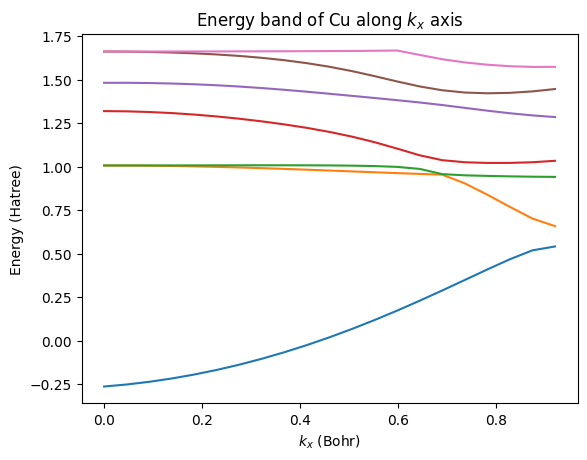

In [9]:
#Graphs 
kx = list(map(lambda k: k[0],ks2))

for i in range(1,8):
    plt.plot(kx,Es2[:,i])
plt.title(r"Energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hatree)")
plt.show()